In [ ]:
#default_exp torch_core

In [ ]:
#export
from fastai2.test import *
from fastai2.core.all import *
from fastai2.torch_imports import *
from fastprogress.fastprogress import progress_bar,master_bar

In [ ]:
from nbdev.showdoc import *
from PIL import Image

In [ ]:
#export
_all_ = ['progress_bar','master_bar']

In [ ]:
#export
if torch.cuda.is_available():
    if torch.cuda.current_device()==0:
        torch.cuda.set_device(int(os.environ.get('DEFAULT_GPU') or 0))
    torch.backends.cudnn.benchmark = True

# Torch Core

> Basic pytorch functions used in the fastai library

## Basics

In [ ]:
#export
@patch
def __array_eq__(self:Tensor,b):
    return torch.equal(self,b) if self.dim() else self==b

In [ ]:
#export
def _array2tensor(x):
    if x.dtype==np.uint16: x = x.astype(np.float32)
    return torch.from_numpy(x)

In [ ]:
#export
def tensor(x, *rest, **kwargs):
    "Like `torch.as_tensor`, but handle lists too, and can pass multiple vector elements directly."
    if len(rest): x = (x,)+rest
    # There was a Pytorch bug in dataloader using num_workers>0. Haven't confirmed if fixed
    # if isinstance(x, (tuple,list)) and len(x)==0: return tensor(0)
    res = (x if isinstance(x, Tensor)
           else torch.tensor(x, **kwargs) if isinstance(x, (tuple,list))
           else _array2tensor(x) if isinstance(x, ndarray)
           else as_tensor(x.values, **kwargs) if isinstance(x, (pd.Series, pd.DataFrame))
           else as_tensor(x, **kwargs) if hasattr(x, '__array__') or is_iter(x)
           else _array2tensor(array(x), **kwargs))
    if res.dtype is torch.float64: return res.float()
    return res

In [ ]:
test_eq(tensor(torch.tensor([1,2,3])), torch.tensor([1,2,3]))
test_eq(tensor(array([1,2,3])), torch.tensor([1,2,3]))
test_eq(tensor(1,2,3), torch.tensor([1,2,3]))
test_eq_type(tensor(1.0), torch.tensor(1.0))

In [ ]:
#export
def set_seed(s):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)

In [ ]:
set_seed(2*33)
a1 = np.random.random()
a2 = torch.rand(())
a3 = random.random()
set_seed(2*33)
b1 = np.random.random()
b2 = torch.rand(())
b3 = random.random()
test_eq(a1,b1)
test_eq(a2,b2)
test_eq(a3,b3)

In [ ]:
#export
def unsqueeze(x, dim=-1, n=1):
    "Same as `torch.unsqueeze` but can add `n` dims"
    for _ in range(n): x = x.unsqueeze(dim)
    return x

In [ ]:
t = tensor([1])
t2 = unsqueeze(t, n=2)
test_eq(t2,t[:,None,None])

In [ ]:
#export
def unsqueeze_(x, dim=-1, n=1):
    "Same as `torch.unsqueeze_` but can add `n` dims"
    for _ in range(n): x.unsqueeze_(dim)
    return x

In [ ]:
t = tensor([1])
unsqueeze_(t, n=2)
test_eq(t, tensor([1]).view(1,1,1))

In [ ]:
#export
def _fa_rebuild_tensor (cls, *args, **kwargs): return cls(torch._utils._rebuild_tensor_v2(*args, **kwargs))
def _fa_rebuild_qtensor(cls, *args, **kwargs): return cls(torch._utils._rebuild_qtensor  (*args, **kwargs))

In [ ]:
#export
def apply(func, x, *args, **kwargs):
    "Apply `func` recursively to `x`, passing on args"
    if is_listy(x): return type(x)([apply(func, o, *args, **kwargs) for o in x])
    if isinstance(x,dict):  return {k: apply(func, v, *args, **kwargs) for k,v in x.items()}
    res = func(x, *args, **kwargs)
    return res if x is None else retain_type(res, x)

In [ ]:
#export
def maybe_gather(x, axis=0):
    "Gather copies of `x` on `axis` is training is distributed"
    if num_distrib()<=1: return x
    ndim = x.ndim
    res = [x.new_zeros(*x.shape if ndim > 0 else (1,)) for _ in range(num_distrib())]
    torch.distributed.all_gather(res, x if ndim > 0 else x[None])
    return torch.cat(res, dim=axis) if ndim > 0 else torch.cat(res, dim=axis).mean()

In [ ]:
#export
def to_detach(b, cpu=True, gather=True):
    "Recursively detach lists of tensors in `b `; put them on the CPU if `cpu=True`."
    def _inner(x, cpu=True, gather=True):
        if not isinstance(x,Tensor): return x
        x = x.detach()
        if gather: x = maybe_gather(x)
        return x.cpu() if cpu else x
    return apply(_inner, b, cpu=cpu, gather=gather)

`gather` only applies during distributed training and the result tensor will be the one gathered accross processes if `gather=True` (as a result, the batch size will be multiplied by the number of processes).

In [ ]:
#export
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

In [ ]:
#export
def to_float(b):
    "Recursively map lists of int tensors in `b ` to float."
    return apply(lambda x: x.float() if torch.is_floating_point(x) else x, b)

In [ ]:
#export
# None: True if available; True: error if not availabe; False: use CPU
defaults.use_cuda = None

In [ ]:
#export
def default_device(use_cuda=-1):
    "Return or set default device; `use_cuda`: None - CUDA if available; True - error if not availabe; False - CPU"
    if use_cuda != -1: defaults.use_cuda=use_cuda
    use = defaults.use_cuda or (torch.cuda.is_available() and defaults.use_cuda is None)
    assert torch.cuda.is_available() or not use
    return torch.device(torch.cuda.current_device()) if use else torch.device('cpu')

In [ ]:
#cuda
_td = torch.device(torch.cuda.current_device())
test_eq(default_device(None), _td)
test_eq(default_device(True), _td)
test_eq(default_device(False), torch.device('cpu'))
default_device(None);

In [ ]:
#export
def to_device(b, device=None):
    "Recursively put `b` on `device`."
    if device is None: device=default_device()
    def _inner(o): return o.to(device, non_blocking=True) if isinstance(o,Tensor) else o
    return apply(_inner, b)

In [ ]:
t = to_device((3,(tensor(3),tensor(2))))
t1,(t2,t3) = t
test_eq_type(t,(3,(tensor(3).cuda(),tensor(2).cuda())))
test_eq(t2.type(), "torch.cuda.LongTensor")
test_eq(t3.type(), "torch.cuda.LongTensor")

In [ ]:
#export
def to_cpu(b):
    "Recursively map lists of tensors in `b ` to the cpu."
    return to_device(b,'cpu')

In [ ]:
t3 = to_cpu(t3)
test_eq(t3.type(), "torch.LongTensor")
test_eq(t3, 2)

In [ ]:
#export
def to_np(x):
    "Convert a tensor to a numpy array."
    return apply(lambda o: o.data.cpu().numpy(), x)

In [ ]:
t3 = to_np(t3)
test_eq(type(t3), np.ndarray)
test_eq(t3, 2)

In [ ]:
#export
def to_concat(xs, dim=0):
    "Concat the element in `xs` (recursively if they are tuples/lists of tensors)"
    if is_listy(xs[0]): return type(xs[0])([to_concat([x[i] for x in xs], dim=dim) for i in range_of(xs[0])])
    if isinstance(xs[0],dict):  return {k: to_concat([x[k] for x in xs], dim=dim) for k in xs.keys()}
    #We may receives xs that are not concatenatable (inputs of a text classifier for instance), in this case we return a big list
    try:    return retain_type(torch.cat(xs, dim=dim), xs[0])
    except: return sum([L(retain_type(o_.index_select(dim, tensor(i)).squeeze(dim), xs[0]) for i in range_of(o_)) for o_ in xs], L())

In [ ]:
test_eq(to_concat([tensor([1,2]), tensor([3,4])]), tensor([1,2,3,4]))
test_eq(to_concat([tensor([[1,2]]), tensor([[3,4]])], dim=1), tensor([[1,2,3,4]]))
test_eq_type(to_concat([(tensor([1,2]), tensor([3,4])), (tensor([3,4]), tensor([5,6]))]), (tensor([1,2,3,4]), tensor([3,4,5,6])))
test_eq_type(to_concat([[tensor([1,2]), tensor([3,4])], [tensor([3,4]), tensor([5,6])]]), [tensor([1,2,3,4]), tensor([3,4,5,6])])
test_eq_type(to_concat([(tensor([1,2]),), (tensor([3,4]),)]), (tensor([1,2,3,4]),))

test_eq(to_concat([tensor([[1,2]]), tensor([[3,4], [5,6]])], dim=1), [tensor([1]),tensor([3, 5]),tensor([4, 6])])

## Tensor subtypes

In [ ]:
#export
class TensorBase(Tensor):
    def __new__(cls, x, **kwargs):
        res = torch.Tensor._make_subclass(cls, tensor(x))
        res._meta = kwargs
        return res

    def __reduce_ex__(self,proto):
        torch.utils.hooks.warn_if_has_hooks(self)
        args = (type(self), self.storage(), self.storage_offset(), tuple(self.size()), self.stride())
        if self.is_quantized: args = args + (self.q_scale(), self.q_zero_point())
        f = _fa_rebuild_qtensor if self.is_quantized else  _fa_rebuild_tensor
        return (f, args + (self.requires_grad, OrderedDict()))

    def gi(self, i):
        res = self[i]
        return type(self)(res) if isinstance(res,Tensor) else res

In [ ]:
#export
def _patch_tb():
    if getattr(TensorBase,'_patched',False): return
    TensorBase._patched = True

    def get_f(fn):
        def _f(self, *args, **kwargs):
            cls = self.__class__
            res = getattr(super(TensorBase, self), fn)(*args, **kwargs)
            return cls(res) if isinstance(res,Tensor) else res
        return _f

    t = tensor([1])
    skips = '__getitem__ __class__ __deepcopy__ __delattr__ __dir__ __doc__ __getattribute__ __hash__ __init__ \
        __init_subclass__ __new__ __reduce__ __reduce_ex__ __module__ __setstate__'.split()

    for fn in dir(t):
        if fn in skips: continue
        f = getattr(t, fn)
        if isinstance(f, (MethodWrapperType, BuiltinFunctionType, BuiltinMethodType, MethodType, FunctionType)):
            setattr(TensorBase, fn, get_f(fn))

_patch_tb()

In [ ]:
#export 
class TensorCategory(TensorBase): pass

In [ ]:
#export 
class TensorMultiCategory(TensorCategory): pass

In [ ]:
class _T(TensorBase): pass

t = _T(range(5))
test_eq(t[0], 0)
test_eq_type(t.gi(0), _T(0))
test_eq_type(t.gi(slice(2)), _T([0,1]))
test_eq_type(t+1, _T(range(1,6)))

test_eq(type(pickle.loads(pickle.dumps(t))), _T)

In [ ]:
t = tensor([1,2,3])
m = TensorBase([False,True,True])
test_eq(t[m], tensor([2,3]))

t = tensor([[1,2,3],[1,2,3]])
m = TensorBase([[False,True,True],
                [False,True,True]])
test_eq(t[m], tensor([2,3,2,3]))

In [ ]:
t = TensorBase([[1,2,3],[1,2,3]], a=1)
test_eq(t._meta, {'a': 1})
x = retain_type(tensor([4,5,6]), t)
test_eq(x._meta, {'a': 1})

In [ ]:
#export
class TensorImageBase(TensorBase):
    _show_args = ArrayImageBase._show_args
    def show(self, ctx=None, **kwargs):
        return show_image(self, ctx=ctx, **{**self._show_args, **kwargs})

In [ ]:
#export
class TensorImage(TensorImageBase): pass

In [ ]:
#export
class TensorImageBW(TensorImage): _show_args = ArrayImageBW._show_args

In [ ]:
#export
class TensorMask(TensorImageBase): _show_args = ArrayMask._show_args

In [ ]:
im = Image.open(TEST_IMAGE)

In [ ]:
im_t = TensorImage(array(im))
test_eq(type(im_t), TensorImage)

In [ ]:
im_t2 = TensorMask(tensor(1))
test_eq(type(im_t2), TensorMask)
test_eq(im_t2, tensor(1))

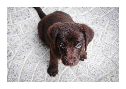

In [ ]:
ax = im_t.show(figsize=(2,2))

In [ ]:
test_fig_exists(ax)

In [ ]:
#hide (last test of to_concat)
test_eq_type(to_concat([TensorImage([1,2]), TensorImage([3,4])]), TensorImage([1,2,3,4]))

## L -

In [ ]:
#export
@patch
def tensored(self:L):
    "`mapped(tensor)`"
    return self.map(tensor)
@patch
def stack(self:L, dim=0):
    "Same as `torch.stack`"
    return torch.stack(list(self.tensored()), dim=dim)
@patch
def cat  (self:L, dim=0):
    "Same as `torch.cat`"
    return torch.cat  (list(self.tensored()), dim=dim)

In [ ]:
show_doc(L.tensored)

<h4 id="L.tensored" class="doc_header"><code>L.tensored</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>L.tensored</code>()

`mapped(tensor)`

There are shortcuts for `torch.stack` and `torch.cat` if your `L` contains tensors or something convertible. You can manually convert with `tensored`.

In [ ]:
t = L(([1,2],[3,4]))
test_eq(t.tensored(), [tensor(1,2),tensor(3,4)])

In [ ]:
show_doc(L.stack)

<h4 id="L.stack" class="doc_header"><code>L.stack</code><a href="__main__.py#L6" class="source_link" style="float:right">[source]</a></h4>

> <code>L.stack</code>(**`dim`**=*`0`*)

Same as `torch.stack`

In [ ]:
test_eq(t.stack(), tensor([[1,2],[3,4]]))

In [ ]:
show_doc(L.cat)

<h4 id="L.cat" class="doc_header"><code>L.cat</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>L.cat</code>(**`dim`**=*`0`*)

Same as `torch.cat`

In [ ]:
test_eq(t.cat(), tensor([1,2,3,4]))

## Chunks

In [ ]:
#export
def concat(*ls):
    "Concatenate tensors, arrays, lists, or tuples"
    if not len(ls): return []
    it = ls[0]
    if isinstance(it,torch.Tensor): res = torch.cat(ls)
    elif isinstance(it,ndarray): res = np.concatenate(ls)
    else:
        res = itertools.chain.from_iterable(map(L,ls))
        if isinstance(it,(tuple,list)): res = type(it)(res)
        else: res = L(res)
    return retain_type(res, it)

In [ ]:
a,b,c = [1],[1,2],[1,1,2]
test_eq(concat(a,b), c)
test_eq_type(concat(tuple (a),tuple (b)), tuple (c))
test_eq_type(concat(array (a),array (b)), array (c))
test_eq_type(concat(tensor(a),tensor(b)), tensor(c))
test_eq_type(concat(TensorBase(a),TensorBase(b)), TensorBase(c))
test_eq_type(concat([1,1],1), [1,1,1])
test_eq_type(concat(1,1,1), L(1,1,1))
test_eq_type(concat(L(1,2),1), L(1,2,1))

In [ ]:
#export
class Chunks:
    "Slice and int indexing into a list of lists"
    def __init__(self, chunks, lens=None):
        self.chunks = chunks
        self.lens = L(map(len,self.chunks) if lens is None else lens)
        self.cumlens = np.cumsum(0+self.lens)
        self.totlen = self.cumlens[-1]

    def __getitem__(self,i):
        if isinstance(i,slice): return retain_type(self.getslice(i), old=self.chunks[0])
        di,idx = self.doc_idx(i)
        return retain_type(self.chunks[di][idx], old=self.chunks[0])

    def getslice(self, i):
        st_d,st_i = self.doc_idx(ifnone(i.start,0))
        en_d,en_i = self.doc_idx(ifnone(i.stop,self.totlen+1))
        res = [self.chunks[st_d][st_i:(en_i if st_d==en_d else sys.maxsize)]]
        for b in range(st_d+1,en_d): res.append(self.chunks[b])
        if st_d!=en_d and en_d<len(self.chunks): res.append(self.chunks[en_d][:en_i])
        return concat(*res)

    def doc_idx(self, i):
        if i<0: i=self.totlen+i # count from end
        docidx = np.searchsorted(self.cumlens, i+1)-1
        cl = self.cumlens[docidx]
        return docidx,i-cl

In [ ]:
docs = L(list(string.ascii_lowercase[a:b]) for a,b in ((0,3),(3,7),(7,8),(8,16),(16,24),(24,26)))

b = Chunks(docs)
test_eq([b[ o] for o in range(0,5)], ['a','b','c','d','e'])
test_eq([b[-o] for o in range(1,6)], ['z','y','x','w','v'])
test_eq(b[6:13], 'g,h,i,j,k,l,m'.split(','))
test_eq(b[20:77], 'u,v,w,x,y,z'.split(','))
test_eq(b[:5], 'a,b,c,d,e'.split(','))
test_eq(b[:2], 'a,b'.split(','))

In [ ]:
t = torch.arange(26)
docs = L(t[a:b] for a,b in ((0,3),(3,7),(7,8),(8,16),(16,24),(24,26)))
b = Chunks(docs)
test_eq([b[ o] for o in range(0,5)], range(0,5))
test_eq([b[-o] for o in range(1,6)], [25,24,23,22,21])
test_eq(b[6:13], torch.arange(6,13))
test_eq(b[20:77], torch.arange(20,26))
test_eq(b[:5], torch.arange(5))
test_eq(b[:2], torch.arange(2))

In [ ]:
docs = L(TensorBase(t[a:b]) for a,b in ((0,3),(3,7),(7,8),(8,16),(16,24),(24,26)))
b = Chunks(docs)
test_eq_type(b[:2], TensorBase(range(2)))
test_eq_type(b[:5], TensorBase(range(5)))
test_eq_type(b[9:13], TensorBase(range(9,13)))

## Other functions

In [ ]:
#export
def one_param(m):
    "First parameter in `m`"
    return first(m.parameters())

In [ ]:
#export
def item_find(x, idx=0):
    "Recursively takes the `idx`-th element of `x`"
    if is_listy(x): return item_find(x[idx])
    if isinstance(x,dict):
        key = list(x.keys())[idx] if isinstance(idx, int) else idx
        return item_find(x[key])
    return x

In [ ]:
#export
def find_device(b):
    "Recursively search the device of `b`."
    return item_find(b).device

In [ ]:
dev = default_device()
test_eq(find_device(t2), dev)
test_eq(find_device([t2,t2]), dev)
test_eq(find_device({'a':t2,'b':t2}), dev)
test_eq(find_device({'a':[[t2],[t2]],'b':t2}), dev)

In [ ]:
#export
def find_bs(b):
    "Recursively search the batch size of `b`."
    return item_find(b).shape[0]

In [ ]:
x = torch.randn(4,5)
test_eq(find_bs(x), 4)
test_eq(find_bs([x, x]), 4)
test_eq(find_bs({'a':x,'b':x}), 4)
test_eq(find_bs({'a':[[x],[x]],'b':x}), 4)

In [ ]:
def np_func(f):
    "Convert a function taking and returning numpy arrays to one taking and returning tensors"
    def _inner(*args, **kwargs):
        nargs = [to_np(arg) if isinstance(arg,Tensor) else arg for arg in args]
        return tensor(f(*nargs, **kwargs))
    functools.update_wrapper(_inner, f)
    return _inner

This decorator is particularly useful for using numpy functions as fastai metrics, for instance:

In [ ]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, inp)

a1,a2 = array([0,1,1]),array([1,0,1])
t = f1(tensor(a1),tensor(a2))
test_eq(f1_score(a1,a2), t)
assert isinstance(t,Tensor)

In [ ]:
#export
class Module(nn.Module, metaclass=PrePostInitMeta):
    "Same as `nn.Module`, but no need for subclasses to call `super().__init__`"
    def __pre_init__(self, *args, **kwargs): super().__init__()
    def __init__(self): pass

In [ ]:
show_doc(Module, title_level=3)

<h3 id="Module" class="doc_header"><code>class</code> <code>Module</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>Module</code>() :: [`Module`](/torch.core.html#Module)

Same as `nn.Module`, but no need for subclasses to call `super().__init__`

In [ ]:
class _T(Module):
    def __init__(self): self.f = nn.Linear(1,1)
    def forward(self,x): return self.f(x)

t = _T()
t(tensor([1.]))

tensor([-0.4176], grad_fn=<AddBackward0>)

In [ ]:
# export
from torch.nn.parallel import DistributedDataParallel

def get_model(model):
    "Return the model maybe wrapped inside `model`."
    return model.module if isinstance(model, (DistributedDataParallel, nn.DataParallel)) else model

In [ ]:
# export
def one_hot(x, c):
    "One-hot encode `x` with `c` classes."
    res = torch.zeros(c, dtype=torch.uint8)
    if isinstance(x, Tensor) and x.numel()>0: res[x] = 1.
    else: res[list(L(x, use_list=None))] = 1.
    return res

In [ ]:
test_eq(one_hot([1,4], 5), tensor(0,1,0,0,1).byte())
test_eq(one_hot(torch.tensor([]), 5), tensor(0,0,0,0,0).byte())
test_eq(one_hot(2, 5), tensor(0,0,1,0,0).byte())

In [ ]:
#export
def one_hot_decode(x, vocab=None):
    return L(vocab[i] if vocab else i for i,x_ in enumerate(x) if x_==1)

In [ ]:
test_eq(one_hot_decode(tensor(0,1,0,0,1)), [1,4])
test_eq(one_hot_decode(tensor(0,0,0,0,0)), [   ])
test_eq(one_hot_decode(tensor(0,0,1,0,0)), [2  ])

In [ ]:
#export
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]

In [ ]:
#export
def trainable_params(m):
    "Return all trainable parameters of `m`"
    return [p for p in m.parameters() if p.requires_grad]

In [ ]:
m = nn.Linear(4,5)
test_eq(trainable_params(m), [m.weight, m.bias])
m.weight.requires_grad_(False)
test_eq(trainable_params(m), [m.bias])

In [ ]:
#export
norm_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.InstanceNorm1d, nn.InstanceNorm2d, nn.InstanceNorm3d)

In [ ]:
#export
def bn_bias_params(m, with_bias=True): # TODO: Rename to `norm_bias_params`
    "Return all bias and BatchNorm parameters"
    if isinstance(m, norm_types): return L(m.parameters()) if with_bias else L(m.weight)
    res = L(m.children()).map(bn_bias_params, with_bias=with_bias).concat()
    if with_bias and getattr(m, 'bias', None) is not None: res.append(m.bias)
    return res

In [ ]:
for norm_func in [nn.BatchNorm1d, partial(nn.InstanceNorm1d, affine=True)]:
    model = nn.Sequential(nn.Linear(10,20), norm_func(20), nn.Conv1d(3,4, 3))
    test_eq(bn_bias_params(model), [model[0].bias, model[1].weight, model[1].bias, model[2].bias])
    model = nn.ModuleList([nn.Linear(10,20, bias=False), nn.Sequential(norm_func(20), nn.Conv1d(3,4,3))])
    test_eq(bn_bias_params(model), [model[1][0].weight, model[1][0].bias, model[1][1].bias])
    model = nn.ModuleList([nn.Linear(10,20), nn.Sequential(norm_func(20), nn.Conv1d(3,4,3))])
    test_eq(bn_bias_params(model, with_bias=False), [model[1][0].weight])

In [ ]:
#export
def batch_to_samples(b, max_n=10):
    "'Transposes' a batch to (at most `max_n`) samples"
    if isinstance(b, Tensor): return retain_types(list(b[:max_n]), [b])
    else:
        res = L(b).map(partial(batch_to_samples,max_n=max_n))
        return retain_types(res.zip(), [b])

In [ ]:
t = tensor([1,2,3])
test_eq(batch_to_samples([t,t+1], max_n=2), ([1,2],[2,3]))
test_eq(batch_to_samples(tensor([1,2,3]), 10), [1, 2, 3])
test_eq(batch_to_samples([tensor([1,2,3]), tensor([4,5,6])], 10), [(1, 4), (2, 5), (3, 6)])
test_eq(batch_to_samples([tensor([1,2,3]), tensor([4,5,6])], 2), [(1, 4), (2, 5)])
test_eq(batch_to_samples([tensor([1,2,3]), [tensor([4,5,6]),tensor([7,8,9])]], 10), 
        [(1, (4, 7)), (2, (5, 8)), (3, (6, 9))])
test_eq(batch_to_samples([tensor([1,2,3]), [tensor([4,5,6]),tensor([7,8,9])]], 2), [(1, (4, 7)), (2, (5, 8))])

t = Tuple(tensor([1,2,3]),TensorBase([2,3,4]))
test_eq_type(batch_to_samples(t)[0][1], TensorBase(2))
test_eq(batch_to_samples(t).map(type), [Tuple]*3)

In [ ]:
#export
@patch
def interp_1d(x:Tensor, xp, fp):
    "Same as `np.interp`"
    slopes = (fp[1:]-fp[:-1])/(xp[1:]-xp[:-1])
    incx = fp[:-1] - (slopes*xp[:-1])
    locs = (x[:,None]>=xp[None,:]).long().sum(1)-1
    locs = locs.clamp(0,len(slopes)-1)
    return slopes[locs]*x + incx[locs]

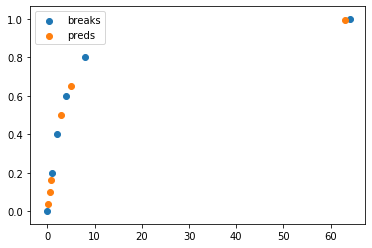

In [ ]:
brks = tensor(0,1,2,4,8,64).float()
ys = tensor(range_of(brks)).float()
ys /= ys[-1].item()
pts = tensor(0.2,0.5,0.8,3,5,63)

preds = pts.interp_1d(brks, ys)
test_close(preds.numpy(), np.interp(pts.numpy(), brks.numpy(), ys.numpy()))

plt.scatter(brks,ys)
plt.scatter(pts,preds)
plt.legend(['breaks','preds']);

In [ ]:
# export
def logit(x):
    "Logit of `x`, clamped to avoid inf."
    x = x.clamp(1e-7, 1-1e-7)
    return -(1/x-1).log()

In [ ]:
#export
def num_distrib():
    "Return the number of processes in distributed training (if applicable)."
    return int(os.environ.get('WORLD_SIZE', 0))

In [ ]:
#export
def rank_distrib():
    "Return the distributed rank of this process (if applicable)."
    return int(os.environ.get('RANK', 0))

In [ ]:
#export
def distrib_barrier():
    "Place a synchronization barrier in distributed training so that ALL sub-processes in the pytorch process group must arrive here before proceeding."
    if num_distrib() > 1: torch.distributed.barrier()

In [ ]:
#export
# Saving arrays requires pytables - optional dependency
try: import tables
except: pass

In [ ]:
#export
def _comp_filter(lib='lz4',lvl=3): return tables.Filters(complib=f'blosc:{lib}', complevel=lvl)

In [ ]:
#export
@patch
def save_array(p:Path, o, complib='lz4', lvl=3):
    "Save numpy array to a compressed `pytables` file, using compression level `lvl`"
    if isinstance(o,Tensor): o = to_np(o)
    with tables.open_file(p, mode='w', filters=_comp_filter(lib=complib,lvl=lvl)) as f: f.create_carray('/', 'data', obj=o)

Compression lib can be any of: blosclz, lz4, lz4hc, snappy, zlib or zstd.

In [ ]:
#export
@patch
def load_array(p:Path):
    "Save numpy array to a `pytables` file"
    with tables.open_file(p, 'r') as f: return f.root.data.read()

## Image helpers

In [ ]:
#export
def make_cross_image(bw=True):
    "Create a tensor containing a cross image, either `bw` (True) or color"
    if bw:
        im = torch.zeros(5,5)
        im[2,:] = 1.
        im[:,2] = 1.
    else:
        im = torch.zeros(3,5,5)
        im[0,2,:] = 1.
        im[1,:,2] = 1.
    return im

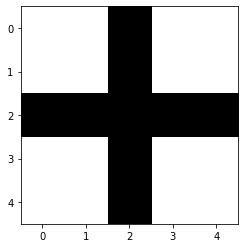

In [ ]:
plt.imshow(make_cross_image(), cmap="Greys");

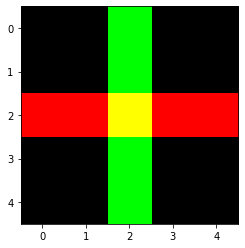

In [ ]:
plt.imshow(make_cross_image(False).permute(1,2,0));

In [ ]:
#export
def show_image_batch(b, show=show_titled_image, items=9, cols=3, figsize=None, **kwargs):
    "Display batch `b` in a grid of size `items` with `cols` width"
    if items<cols: cols=items
    rows = (items+cols-1) // cols
    if figsize is None: figsize = (cols*3, rows*3)
    fig,axs = plt.subplots(rows, cols, figsize=figsize)
    for *o,ax in zip(*to_cpu(b), axs.flatten()): show(o, ax=ax, **kwargs)

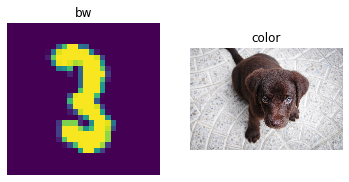

In [ ]:
show_image_batch(([Image.open(TEST_IMAGE_BW),Image.open(TEST_IMAGE)],['bw','color']), items=2)

## Model init

In [ ]:
#export
def requires_grad(m):
    "Check if the first parameter of `m` requires grad or not"
    ps = list(m.parameters())
    return ps[0].requires_grad if len(ps)>0 else False

In [ ]:
tst = nn.Linear(4,5)
assert requires_grad(tst)
for p in tst.parameters(): p.requires_grad_(False)
assert not requires_grad(tst)

In [ ]:
#export
def init_default(m, func=nn.init.kaiming_normal_):
    "Initialize `m` weights with `func` and set `bias` to 0."
    if func:
        if hasattr(m, 'weight'): func(m.weight)
        if hasattr(m, 'bias') and hasattr(m.bias, 'data'): m.bias.data.fill_(0.)
    return m

In [ ]:
tst = nn.Linear(4,5)
tst.weight.data.uniform_(-1,1)
tst.bias.data.uniform_(-1,1)
tst = init_default(tst, func = lambda x: x.data.fill_(1.))
test_eq(tst.weight, torch.ones(5,4))
test_eq(tst.bias, torch.zeros(5))

In [ ]:
#export
def cond_init(m, func):
    "Apply `init_default` to `m` unless it's a batchnorm module"
    if (not isinstance(m, norm_types)) and requires_grad(m): init_default(m, func)

In [ ]:
tst = nn.Linear(4,5)
tst.weight.data.uniform_(-1,1)
tst.bias.data.uniform_(-1,1)
cond_init(tst, func = lambda x: x.data.fill_(1.))
test_eq(tst.weight, torch.ones(5,4))
test_eq(tst.bias, torch.zeros(5))

tst = nn.BatchNorm2d(5)
init = [tst.weight.clone(), tst.bias.clone()]
cond_init(tst, func = lambda x: x.data.fill_(1.))
test_eq(tst.weight, init[0])
test_eq(tst.bias, init[1])

In [ ]:
#export
def apply_leaf(m, f):
    "Apply `f` to children of `m`."
    c = m.children()
    if isinstance(m, nn.Module): f(m)
    for l in c: apply_leaf(l,f)

In [ ]:
tst = nn.Sequential(nn.Linear(4,5), nn.Sequential(nn.Linear(4,5), nn.Linear(4,5)))
apply_leaf(tst, partial(init_default, func=lambda x: x.data.fill_(1.)))
for l in [tst[0], *tst[1]]: test_eq(l.weight, torch.ones(5,4))
for l in [tst[0], *tst[1]]: test_eq(l.bias,   torch.zeros(5))

In [ ]:
#export
def apply_init(m, func=nn.init.kaiming_normal_):
    "Initialize all non-batchnorm layers of `m` with `func`."
    apply_leaf(m, partial(cond_init, func=func))

In [ ]:
tst = nn.Sequential(nn.Linear(4,5), nn.Sequential(nn.Linear(4,5), nn.BatchNorm1d(5)))
init = [tst[1][1].weight.clone(), tst[1][1].bias.clone()]
apply_init(tst, func=lambda x: x.data.fill_(1.))
for l in [tst[0], tst[1][0]]: test_eq(l.weight, torch.ones(5,4))
for l in [tst[0], tst[1][0]]: test_eq(l.bias,   torch.zeros(5))
test_eq(tst[1][1].weight, init[0])
test_eq(tst[1][1].bias,   init[1])

## Multiprocessing

In [ ]:
#export
from multiprocessing import Process, Queue

In [ ]:
#export
def set_num_threads(nt):
    "Get numpy (and others) to use `nt` threads"
    try: import mkl; mkl.set_num_threads(nt)
    except: pass
    torch.set_num_threads(1)
    os.environ['IPC_ENABLE']='1'
    for o in ['OPENBLAS_NUM_THREADS','NUMEXPR_NUM_THREADS','OMP_NUM_THREADS','MKL_NUM_THREADS']:
        os.environ[o] = str(nt)

In [ ]:
#export 
@delegates(concurrent.futures.ProcessPoolExecutor)
class ProcessPoolExecutor(concurrent.futures.ProcessPoolExecutor):
    def __init__(self, max_workers=None, on_exc=print, **kwargs):
        self.not_parallel = max_workers==0
        self.on_exc = on_exc
        if self.not_parallel: max_workers=1
        super().__init__(max_workers, **kwargs)

    def map(self, f, items, *args, **kwargs):
        g = partial(f, *args, **kwargs)
        if self.not_parallel: return map(g, items)
        try: return super().map(g, items)
        except Exception as e: self.on_exc(e)

In [ ]:
#export 
def parallel(f, items, *args, n_workers=defaults.cpus, total=None, progress=True, **kwargs):
    "Applies `func` in parallel to `items`, using `n_workers`"
    with ProcessPoolExecutor(n_workers) as ex:
        r = ex.map(f,items, *args, **kwargs)
        if progress:
            if total is None: total = len(items)
            r = progress_bar(r, total=total, leave=False)
        return L(r)

In [ ]:
def add_one(x, a=1): 
    time.sleep(random.random()/100)
    return x+a

inp,exp = range(50),range(1,51)
test_eq(parallel(add_one, inp, n_workers=2), exp)
test_eq(parallel(add_one, inp, n_workers=0), exp)
test_eq(parallel(add_one, inp, n_workers=1, a=2), range(2,52))
test_eq(parallel(add_one, inp, n_workers=0, a=2), range(2,52))

In [ ]:
#export
def run_procs(f, f_done, args):
    "Call `f` for each item in `args` in parallel, yielding `f_done`"
    processes = L(args).map(Process, args=arg0, target=f)
    for o in processes: o.start()
    try: yield from f_done()
    except Exception as e: print(e)
    finally: processes.map(Self.join())

In [ ]:
#export 
def parallel_gen(cls, items, n_workers=defaults.cpus, as_gen=False, **kwargs):
    "Instantiate `cls` in `n_workers` procs & call each on a subset of `items` in parallel."
    batches = np.array_split(items, n_workers)
    idx = np.cumsum(0 + L(batches).map(len))
    queue = Queue()
    def f(batch, start_idx):
        for i,b in enumerate(cls(**kwargs)(batch)): queue.put((start_idx+i,b))
    def done(): return (queue.get() for _ in progress_bar(items, leave=False))
    yield from run_procs(f, done, L(batches,idx).zip())

`cls` is any class with `__call__`. It will be passed `args` and `kwargs` when initialized. Note that `n_workers` instances of `cls` are created, one in each process. `items` are then split in `n_workers` batches and one is sent to each `cls`. The function then returns a list of all the results, matching the order of `items` (if not `as_gen`) or a generator of tuples of item indices and results (if `as_gen`).

In [ ]:
class SleepyBatchFunc:
    def __init__(self): self.a=1
    def __call__(self, batch):
        for k in batch:
            time.sleep(random.random()/4)
            yield k+self.a

x = np.linspace(0,0.99,20)
res = L(parallel_gen(SleepyBatchFunc, x, n_workers=2))
test_eq(res.sorted().itemgot(1), x+1)

## autograd jit functions

In [ ]:
#export
def script_use_ctx(f):
    "Decorator: create jit script and pass everything in `ctx.saved_variables to `f`, after `*args`"
    sf = torch.jit.script(f)
    def _f(ctx, *args, **kwargs): return sf(*args, *ctx.saved_variables, **kwargs)
    return update_wrapper(_f,f)

In [ ]:
#export
def script_save_ctx(static, *argidx):
    "Decorator: create jit script and save args with indices `argidx` using `ctx.save_for_backward`"
    def _dec(f):
        sf = torch.jit.script(f)
        def _f(ctx, *args, **kwargs):
            if argidx:
                save = [args[o] for o in argidx]
                ctx.save_for_backward(*save)
            if not argidx: args = [ctx]+args
            return sf(*args, **kwargs)
        if static: _f = staticmethod(_f)
        return update_wrapper(_f,f)
    return _dec

In [ ]:
#export
def script_fwd(*argidx):
    "Decorator: create static jit script and save args with indices `argidx` using `ctx.save_for_backward`"
    return script_save_ctx(True, *argidx)

In [ ]:
#export
def script_bwd(f):
    "Decorator: create static jit script and pass everything in `ctx.saved_variables to `f`, after `*args`"
    return staticmethod(script_use_ctx(f))

In [ ]:
#export
def grad_module(cls):
    "Decorator: convert `cls` into an autograd function"
    class _c(nn.Module):
        def forward(self, *args, **kwargs): return cls.apply(*args, **kwargs)
    return _c

# Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_test.ipynb.
Converted 01_core.foundation.ipynb.
Converted 01a_core.utils.ipynb.
Converted 01b_core.dispatch.ipynb.
Converted 01c_core.transform.ipynb.
Converted 02_core.script.ipynb.
Converted 03_torch_core.ipynb.
Converted 03a_layers.ipynb.
Converted 04_data.load.ipynb.
Converted 05_data.core.ipynb.
Converted 06_data.transforms.ipynb.
Converted 07_data.block.ipynb.
Converted 08_vision.core.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09a_vision.data.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 13a_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 19_callback.mixup.ipynb.
Converted 20_interpret.ipynb.
